## LSTM - Sine and Tangent Series Classification - Multiclass

Here, we'll use LSTM to classify the Sine series and Tangent series, considering them as the time-series.

**Step 1 : Importing the Libraries**

In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

**Step 2 : Loading or Formulating the dataset**

Here we need to create the random series of both Sine and Tangent. **Sine** would be labeld as **0** and **Tangent** series would be **1**.

The structure of the dataset would be

| X   | y   |
| :---: | :--:|
| $[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$ | 0 |
| $[tan(a), tan(a+1), tan(a+2)..., tan(a+n)]$ | 1 |
| $[sin(b), sin(b+1), sin(b+2)..., sin(b+n)]$ | 0 |
| $[tan(b), tan(b+1), tan(b+2)..., tan(b+n)]$ | 1 |
| $... ... ... ... ...$  | ... |
| $[sin(z), sin(z+1), sin(z+2)..., sin(z+n)]$ | 0 |
| $[tan(z), tan(z+1), tan(z+2)..., tan(z+n)]$ | 1 |

$a ... z$ are the random number between $0 - 100.$<br/>
$n$ is the maximum data points we need. Here we choose it to be 400.<br/>
The rows in the dataset let's say would be $1000$. $500$ for $sin(x)$ and $500$ for $tan(x)$



In [3]:

main_series = []

for _ in range(0,1000):

    rn = np.random.randint(0,100)

    series_1 = []
    series_2 = []    

    for i in range(rn,rn+400):
        series_1.append(np.sin(i) + 1)
        series_2.append(np.abs(np.tan(i)))

    main_series.append((series_1,0))
    main_series.append((series_2,1))

df = pd.DataFrame(main_series, columns=['X','y'])


In [4]:
df.head()

,X,y
0,"[0.0007931658136463016, 0.4936343588902412, 1....",0
1,"[25.092534979676547, 0.5872139151569291, 0.506...",1
2,"[0.2608193033507772, 1.167355700302807, 1.9200...",0
3,"[1.0975097786622852, 0.16974975208268753, 2.34...",1
4,"[0.37011200572554614, 1.313228782433085, 1.968...",0


**Step 2: Train-Test Split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size = 0.20, random_state=42)

**Step 3 : Data Preprocessing**

The output from this would be series, so converting the values to list 

In [6]:
X_train = list(X_train)
X_test = list(X_test)
y_train = list(y_train)
y_test = list(y_test)

Converting the values to the Tensors

In [7]:
x_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

**Step 4 : Modelling**

This part is most important so let's understand this properly.

<hr/>

### Network Initialization

**Input-Output**

Let's talk about input and output of the model first. <br/>

From **Step : 2** we have that the dataset is of $1000$ rows with each row of series length $400$. Therefore, the `self.input_layer_size` will be $400$.

<hr/>

**Hidden Layer**

So the hidden layer could have any number of value. We would need to tweak this value to see when the model performs the best. For now, let's keep this value as $200$.

<hr/>

**LSTM Layer**

As per the parameters defined above the *LSTM* layer would be like :

`self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size)` or ` self.lstm = nn.LSTM(400, 200)`

<hr/>

**Fully Connected Layer**

Now as the output of the *LSTM* layer is $200$, the input of the *Fully Conected* layer, which comes after the *LSTM* layer, should have to be $200$ as well. That is `self.hidden_layer_size` would be $200$.

The output of the *Fully Conected* layer depends upon the number of classes we have in the dataset. For now we have 2 classes, $0$ and $1$. This problem therefore is a *"Multiclass Classification"* problem. This would require the output of the network to be equal to the number of classes we have, since here we have two classes *sine series* and *tangent Series*, the value of output would be $2$. That is `self.output_layer_size` would be $2$

This can be achieved by setting the output of the *Fully Conected* as $2$.

So, as per the parameters defined above the *Fully Conected* layer would be like : 

`self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)` or `self.fc = nn.Linear(200, 2)`

<hr/>

**Hidden Cell**

We know that the *LSTM* cell have two more inputs apart from the data. They are called Hidden State Tensor $h_t$ and Cell State Tensor $c_t$. The dimensions of both $h_t$ and $c_t$ are same. 

Since the network need these as inputs so we need to pass them to the *LSTM* cell as well, although the network doesn't care what the initial values/states of $h_t$ and $c_t$ are, so we initialize them with $0$ Tensor.

Dimension of both $h_t$ and $c_t$ would be : (*number of LSTM layers*, *batch size*, *hidden layer size*)

In our case we have :

*number of LSTM layers* : $1$<br/>
*batch size* : $1$<br/>
*hidden layer size* : $200$

So, the Tensor value for $h_t$ would be = `torch.zeros(1,1,self.hidden_layer_size)`<br/>
the Tensor value for $c_t$ would be = `torch.zeros(1,1,self.hidden_layer_size)`

Here, `self.hidden_cell` is a touple having both `(h_t, c_t)`

<hr/>

**Softmax Activation**

Since this is a *Multiclass Classification Problem* we would need to keep the output of the network between euqual to the number of classes we're classifying. Like if we're are classifying into 2 classes we have the output like : 

`[0.45, 0.55]`

Each value would represent the probability of being classified as the class. So *Class 0* has the probability of $0.45$ and *Class 1* has the probability of $0.55$ . Since the probabilty of class $1$ is highest, the classificaion of the input would be class $1$.

The *Softmax Activation Function* on the output is already there inside the `CrossEntropyLoss` so we do not need to explicitly use it anywhere.

<hr/>

### Forward Function

This is where we'll use the above definations of the layers. This *Forward* function is the one which takes the input during the training of the phase or the prediction phase of the model. In our case, the input to this function `input_seq` is basically one of the following series :

$[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$  for $n=400$

$[tan(a), tan(a+1), tan(a+2)..., tan(a+n)]$ for $n=400$

<hr/>

**LSTM Initialization**

Since the incomming series is of dimension [1 x 400] or [400] which is a single dimensional tensor, we would need to convert it into 3 dimensional tensor i.e. [1,1,400]. This could be done as follows :

`input_seq.view(1 ,1, -1)`

This converted series will then have to be passed to *LSTM* layer's input. Also, we discussed above that the *LSTM Layer* also takes the hidden and cell state $h_t$ and $c_t$ as input. We would need to pass it as well during the layer's initialization along with the 3 dimensional series. This is done as follows:

`self.lstm(input_seq.view(1 ,1, -1), self.hidden_cell)`

Here, the first parameter and the second parameter we know that we should keep them as $1$ and since we don't want to do extra calculation to see what could be the value of the third dimension, we write `-1`. This will automatically calculate the value and assign it to the parameter.

The *LSTM Layer* will output two values after the completion, first would be the output data $\hat{y}$ (`lstm_out`) and the hidden states ($h_t$, $c_t$) (`self.hidden_cell`). **The value of** (`self.hidden_cell`) **is to be passed in the next epoch and this is very important to make sure that this happenes.** So, we've assigned the value of the hidden state ($h_t$, $c_t$) comming back from the *LSTM Layer* to the same variable `self.hidden_cell` so that it will go back into the *LSTM Layer* on the next epoch execution.

<hr/>

**Fully Connected Layer Initialization**

The output `lstm_out` from the *LSTM Layer* which came along with the the hidden states ($h_t$, $c_t$) (`self.hidden_cell`) will be passed to the *Fully Connected Layer*. 

The input to the *Fully Connected Layer* should be a *vector*. So we would need to convert the dimension of `lstm_out` to a single dimensional vector. This can be done using the `view()` function. We pass in this function `view(1,-1)`. Here first parameter is the *number of rows* and second is *number of columns* (for a 2D setting we are saying this). We know that *number of rows* should be $1$ so we pass it as $1$. And since we don't want to do extra calculation to see what could be the value of *number of columns*, we write `-1`. This will automatically calculate the value and assign it to the columns.

The *output* of the *Fully Connected Layer* would be a single value as it has output dimension $1$.

`lstm_out, self.hidden_cell = self.lstm(input_seq.view(1 ,1, -1), self.hidden_cell)`

<hr/>

**Softmax Activation**

The *output* of the *Fully Connected Layer* should be between give the probability of each class for being classified as the class for the input provided. The *Softmax Activation Function* on the output is already there inside the `CrossEntropyLoss` so we do not need to explicitly use it anywhere.

***On a side-note :*** 
*The output from the ***fully connected layer*** (which is an array of value count equals to that of class count) is not the probabilites of the classes unless we pass it through softmax, so what we get here is usually a float value for a class, the higher this value for a class the higher the probability of the class to be the final class. So we take the index of the max of this array i.e. `argmax(array)` which will give the final class.*

<hr/>

Finally, the last value of the array `predictions` would be the return value of the network. This means that the network has classified the given `input_seq` as whatever `predictions[-1]` contains. `predictions` is a tensor of size $[1, 1]$ and have the values like $[[0.34]]$, so to reshape the Tensor to $[0.34]$, we take the last item of it, i.e. $[-1]$. This value will then be matched with the *True value* and an error will be calculated, which then will be use to retrain the network.

In [9]:
class LSTMModule(nn.Module):

    def __init__(self):
        super(LSTMModule, self).__init__()

        self.input_layer_size = 400
        self.hidden_layer_size = 200
        self.output_layer_size = 2

        self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size)
        self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device), torch.zeros(1,1,self.hidden_layer_size).to(device))


    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(1 ,1, -1), self.hidden_cell)
        predictions = self.fc(lstm_out.view(1, -1))
        return predictions[-1]

Defining Loss function and Optimizer for the model training. 

***Loss Function*** -> Cross Entropy Loss since this is a Multiclass classification problem<br/>
***Optimizer*** -> ADAM

In [10]:
model = LSTMModule().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
print(model)

LSTMModule(
  (lstm): LSTM(400, 200)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)


**Step 5 : Model Training**

In [11]:
epochs = 50

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model.train()

for i in range(epochs):

    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    running_loss = 0.0

    for seq, labels in zip(x_train, y_train):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, 200).to(device), torch.zeros(1, 1, 200).to(device))

        y_pred = model(seq)

        single_loss = criterion(y_pred.view(1,-1), labels.view(1))
        single_loss.backward()
        optimizer.step()

        preds = torch.round(y_pred).argmax().to(int).squeeze(0)
        running_corrects += torch.sum(preds == labels)

        running_loss += single_loss.item()


    else:
        with torch.no_grad():
            for val_inputs, val_labels in zip(x_test, y_test):

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs.view(1,-1), val_labels.view(1))
                
                val_preds = torch.round(val_outputs).argmax().to(int).squeeze(0)

                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)

        
    epoch_loss = running_loss/len(x_train)
    epoch_acc = running_corrects.float()/ len(x_train)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_acc = val_running_corrects.float()/ len(x_test)
    val_epoch_loss = val_running_loss/ len(x_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    epoch_list.append(i + 1)

    print("Epoch : ",i + 1)
    print('training loss: {:.4f}, acc {:.4f} '.format(running_loss/len(x_train), epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    print('_'*20)
    

Epoch :  1
training loss: 0.3514, acc 0.8469 
validation loss: 0.6686, validation acc 0.7025 
____________________
Epoch :  2
training loss: 0.1147, acc 0.9775 
validation loss: 0.7805, validation acc 0.7650 
____________________
Epoch :  3
training loss: 0.1103, acc 0.9806 
validation loss: 0.6396, validation acc 0.8200 
____________________
Epoch :  4
training loss: 0.1136, acc 0.9831 
validation loss: 0.4283, validation acc 0.8575 
____________________
Epoch :  5
training loss: 0.1178, acc 0.9831 
validation loss: 0.3163, validation acc 0.8900 
____________________
Epoch :  6
training loss: 0.1205, acc 0.9831 
validation loss: 0.2482, validation acc 0.9075 
____________________
Epoch :  7
training loss: 0.1216, acc 0.9831 
validation loss: 0.2134, validation acc 0.9300 
____________________
Epoch :  8
training loss: 0.1221, acc 0.9831 
validation loss: 0.1941, validation acc 0.9425 
____________________
Epoch :  9
training loss: 0.1224, acc 0.9831 
validation loss: 0.1826, validatio

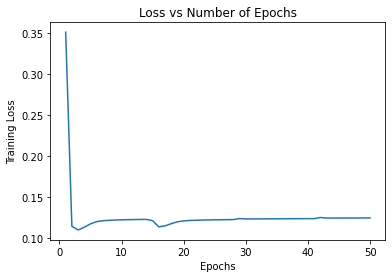

In [12]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

**Step 6 : Evaluating the Model**

Text(69.0, 0.5, 'Predicted Values')

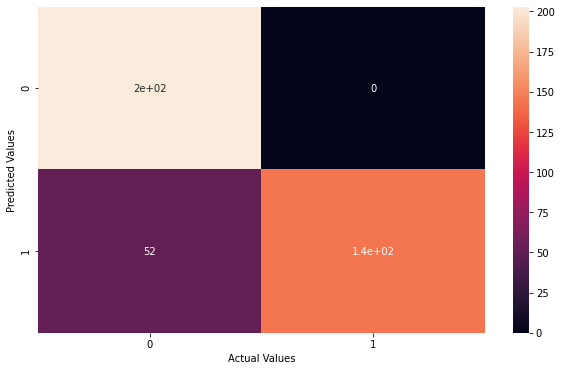

In [17]:
predictions=[]

with torch.no_grad():
        model.eval()

        for inputs, labels in zip(x_test, y_test):

                output = model(inputs)          
                predictions.append(output.argmax().to(int).to('cpu').item())
        
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.to('cpu').numpy(),predictions)
cm

plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')